In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


## 確認裝置

In [17]:
# 1. 裝置設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用裝置：{device}")

使用裝置：cuda:0


## 下載資料集

In [18]:
# 2. 資料前處理與載入
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 隨機裁剪，邊緣補零 CIFAR100 image size = 32x32
    transforms.RandomHorizontalFlip(),      # 隨機水平翻轉
    transforms.ToTensor(),  # 直接將像素從 [0,255] => [0,1]
])

trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:

class CNN2(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        act = nn.ReLU()  # 或改成 nn.GELU()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size =3, padding=1),  # 3通道(32x32)->128通道(32x32)
            nn.BatchNorm2d(128),
            act,
            nn.MaxPool2d(2, 2)                           # 128通道(32x32) -> 128通道(16x16)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3, padding=1),# 128通道(16x16) -> 512通道(16x16)
            nn.BatchNorm2d(512),
            act,
            )
        self.block3 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),# 512通道(16x16) -> 1024通道(16x16)
            nn.BatchNorm2d(1024),
            act,
            nn.MaxPool2d(2, 2)                           # 1024通道(16x16) -> 1024通道(8x8)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(1024, 2048, kernel_size=3, padding=1),# 1024通道(8x8) -> 2048通道(8x8)
            nn.BatchNorm2d(2048),
            act,
            nn.MaxPool2d(2, 2)                           # 2048通道(8x8) -> 2048通道(4x4)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(2048, 4096, kernel_size=3, padding=1),# 2048通道(8x8) -> 4096通道(8x8)
            nn.BatchNorm2d(4096),
            act,
            nn.MaxPool2d(2, 2)                           # 4096通道(4x4) -> 4096通道(2x2)
        )

        self.gap = nn.MaxPool2d(2,2)  # 2x2 -> 1x1
        self.fc1 = nn.Linear(4096, num_classes)
        #self.fc1 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block1(x)   
        x = self.block2(x)   
        x = self.block3(x)   
        x = self.block4(x)   
        x = self.block5(x)   
        x = self.gap(x)      
        x = x.view(x.size(0), -1)  # (B,256)
        x = nn.Dropout(0.3)(x)
        x = self.fc1(x)      # (B,num_classes)
        return x
    
model2 = CNN2().to(device)
print(model2)

# 4. 損失與優化器
criterion = nn.CrossEntropyLoss()  # 直接接收整數標籤
optimizer = optim.Adam(model2.parameters(), lr=0.001)


CNN2(
  (block1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Epoch 1/30 — Train Loss: 4.8563, Train Acc: 0.0471 — Val Loss: 4.6478, Val Acc: 0.0807
Epoch 2/30 — Train Loss: 3.9325, Train Acc: 0.1324 — Val Loss: 3.6739, Val Acc: 0.1530
Epoch 3/30 — Train Loss: 3.3711, Train Acc: 0.2246 — Val Loss: 3.3452, Val Acc: 0.2270
Epoch 4/30 — Train Loss: 2.8941, Train Acc: 0.3099 — Val Loss: 3.4047, Val Acc: 0.2849
Epoch 5/30 — Train Loss: 2.5988, Train Acc: 0.3717 — Val Loss: 2.7730, Val Acc: 0.3493
Epoch 6/30 — Train Loss: 2.2960, Train Acc: 0.4301 — Val Loss: 2.3880, Val Acc: 0.4093
Epoch 7/30 — Train Loss: 2.0710, Train Acc: 0.4760 — Val Loss: 2.3676, Val Acc: 0.4321
Epoch 8/30 — Train Loss: 1.8922, Train Acc: 0.5153 — Val Loss: 2.0951, Val Acc: 0.4829
Epoch 9/30 — Train Loss: 1.7266, Train Acc: 0.5505 — Val Loss: 2.1741, Val Acc: 0.4760
Epoch 10/30 — Train Loss: 1.6030, Train Acc: 0.5788 — Val Loss: 1.7902, Val Acc: 0.5428
Epoch 11/30 — Train Loss: 1.4628, Train Acc: 0.6098 — Val Loss: 2.0842, Val Acc: 0.5021
Epoch 12/30 — Train Loss: 1.3591, Train A

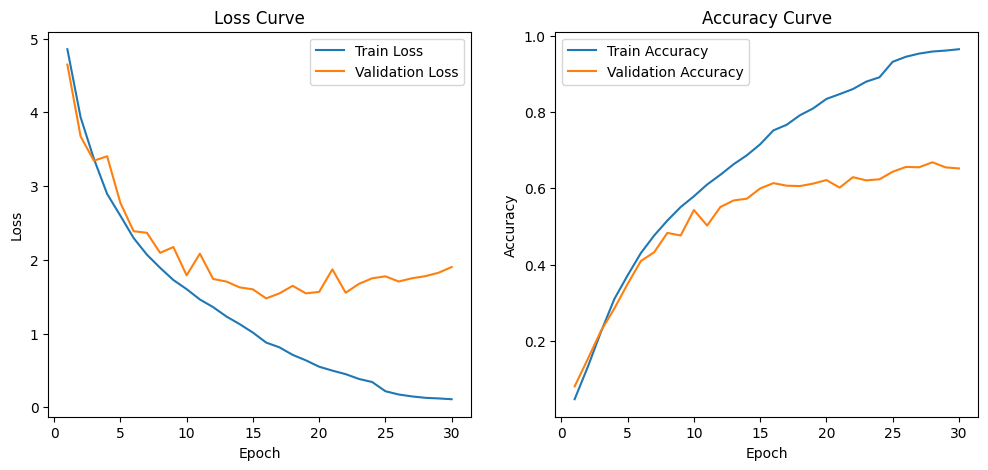

In [20]:
import matplotlib.pyplot as plt

num_epochs = 30

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
lr=0.001

for epoch in range(1, num_epochs + 1):
    # ====== 訓練 ======
    model2.train()
    running_loss = 0.0
    correct, total = 0, 0
    if epoch == 15:
        lr = lr * 0.8
        optimizer = optim.Adam(model2.parameters(), lr=lr) # 降低學習率
    elif epoch == 25:
        lr = lr * 0.5
        optimizer = optim.Adam(model2.parameters(), lr=lr)
    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ====== 驗證 ======
    model2.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model2(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(testloader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} — "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    if train_accuracies[-1] >= 0.99 and val_accuracies[-1] >= 0.7:
        print("達成目標！")
        break

# ====== 畫 Loss 曲線 ======
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# ====== 畫 Accuracy 曲線 ======
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()
